## Chat Message Memory
- We need to store the historical chat messages in a efficient way
- It wraps another Runnable and manages the chat message history for it.
- Specifically, it loads previous messages in the conversation BEFORE passing it to the Runnable, and it saves the generated response as a message AFTER calling the runnable.
-  This class also enables multiple conversations by saving each conversation with a session_id
- it then expects a `session_id` to be passed in the config when calling the runnable, and uses that to look up the relevant conversation history

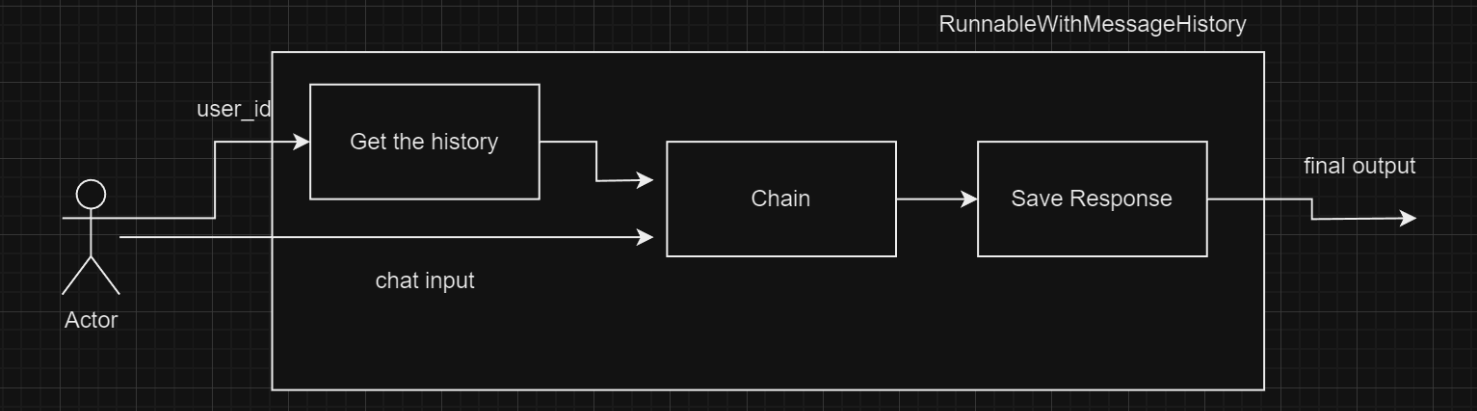

***

In [1]:
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import (SystemMessagePromptTemplate,
                                    HumanMessagePromptTemplate,
                                    ChatPromptTemplate)
from langchain_core.output_parsers import StrOutputParser

In [3]:
base_url = "http://localhost:11434"
model = "llama3.2:3b"

llm = ChatOllama(
    base_url=base_url,
    model=model
)

In [5]:
template = ChatPromptTemplate.from_template(template="{prompt}")

chain = template | llm | StrOutputParser()

about = "My name is Suraj. Im learning Ollama(A framework to run LLM locally) with LangChain"

output = chain.invoke({
    'prompt': about
})

print(output)

Nice to meet you, Suraj!

It sounds like you're exploring Ollama and LangChain, which are both promising frameworks for running Large Language Models (LLMs) locally.

Ollama is a project that aims to provide a unified interface for building and deploying LLMs, while LangChain is an open-source framework that helps you build, deploy, and manage your models in a scalable way.

What specific aspects of Ollama and LangChain are you finding challenging or interesting? Are you working on any projects or experiments with these frameworks? I'm here to help if you need guidance or have questions!


In [6]:
output = chain.invoke({
    'prompt': "What is my name ?"
})

print(output)

I don't have any information about your name. I'm a text-based AI assistant, and our conversation just started. I don't retain any personal data or know anyone's name unless you tell me it. Would you like to share your name with me?


***

### Runnable With Message History

In order to properly set this up there are two main things to consider:
- How to store and load messages?
- What is the underlying Runnable you are wrapping and what are its inputs/outputs?


In [7]:
from langchain_core.prompts import (
                                        SystemMessagePromptTemplate,
                                        HumanMessagePromptTemplate,
                                        ChatPromptTemplate
                                        )

from langchain_core.output_parsers import StrOutputParser

from langchain_core.messages import HumanMessage
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import SQLChatMessageHistory

In [8]:
def get_session_history(session_id):
    return SQLChatMessageHistory(session_id=session_id, connection="sqlite:///chat_history.db")

In [9]:
runnable_with_history = RunnableWithMessageHistory(runnable=chain, get_session_history=get_session_history)

In [12]:
user_id = 'suraj-12345'
history = get_session_history(session_id=user_id)

history.get_messages()

[]

In [23]:
def get_user_history(user_id):
    history = get_session_history(session_id=user_id)
    return history.get_messages()

In [ ]:
history.clear()  # to clear the history for that session_id

In [13]:
about

'My name is Suraj. Im learning Ollama(A framework to run LLM locally) with LangChain'

In [14]:
output = runnable_with_history.invoke([HumanMessage(content=about)], config={'configurable': {'session_id': user_id}})

In [15]:
print(output)

It looks like you're using a messaging system, possibly from the LangChain framework.

You've sent a message indicating that your name is Suraj and you're learning about Ollemma (a framework for running Large Language Models locally).


In [17]:
output = runnable_with_history.invoke([HumanMessage(content="What is my name ?")], config={'configurable': {'session_id': user_id}})

print(output)

This appears to be an AI system's internal log or message dump. Let me break it down:

1. The first line:
   ```
[HumanMessage(content='My name is Suraj. Im learning Ollama(A framework to run LLM locally) with LangChain', additional_kwargs={}, response_metadata={})}
```
   This indicates a human has sent a message, identified as a `HumanMessage`, containing the text "My name is Suraj. Im learning Ollama(A framework to run LLM locally) with LangChain". The `additional_kwargs` and `response_metadata` variables are empty in this case.

2. The second line:
   ```
AIMessage(content="It looks like you're using a messaging system, possibly from the LangChain framework.\n\nYou've sent a message indicating that your name is Suraj and you're learning about Ollemma (a framework for running Large Language Models locally).", additional_kwargs={}, response_metadata={})
```
   This indicates an `AIMessage` has been generated by the AI system in response to the previous human's message. The content of

***

### Message History with Dictionary Like Inputs

In [18]:
from langchain_core.prompts import (
                                        SystemMessagePromptTemplate,
                                        HumanMessagePromptTemplate,
                                        ChatPromptTemplate,
                                        MessagesPlaceholder
                                        )

from langchain_core.output_parsers import StrOutputParser

In [19]:
system = SystemMessagePromptTemplate.from_template("You are helpful AI Assistent.")
human = HumanMessagePromptTemplate.from_template("{input}")

messages = [system, MessagesPlaceholder(variable_name='history'), human]

prompt = ChatPromptTemplate.from_messages(messages=messages)

chain = prompt | llm | StrOutputParser()

runnable_with_history = RunnableWithMessageHistory(
    runnable=chain,
    get_session_history=get_session_history,
    input_messages_key='input',
    history_messages_key='history'
)

In [21]:
def chat_with_llm(session_id, input):
    output = runnable_with_history.invoke({'input': input}, 
                                          config={'configurable': {'session_id': session_id}})
    
    return output

In [25]:
user_id = "sam"
chat_with_llm(user_id, about)

"Nice to meet you, Suraj! \n\nIt sounds like you're exploring the world of Large Language Models (LLMs) and LangChain, a framework that allows you to run these models locally on your own machine.\n\nLangChain is indeed a great tool for running LLMs in a local environment, which can be more efficient and private than relying on cloud-based services. By using LangChain, you're essentially decoupling the model from its training data and deployment infrastructure, making it easier to manage and maintain your models.\n\nOllama is another interesting project that aims to make it easy to train, deploy, and manage LLMs. It's great that you're learning about these frameworks!\n\nWhat specific aspects of LangChain and Ollama are you currently working on or struggling with? I'm here to help if you need guidance or clarification!"

In [27]:
chat_with_llm(user_id, "what is my name?")

'Your name is Suraj.'

In [28]:
get_user_history(user_id)

[HumanMessage(content='My name is Suraj. Im learning Ollama(A framework to run LLM locally) with LangChain', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Nice to meet you, Suraj! \n\nIt sounds like you're exploring the world of Large Language Models (LLMs) and LangChain, a framework that allows you to run these models locally on your own machine.\n\nLangChain is indeed a great tool for running LLMs in a local environment, which can be more efficient and private than relying on cloud-based services. By using LangChain, you're essentially decoupling the model from its training data and deployment infrastructure, making it easier to manage and maintain your models.\n\nOllama is another interesting project that aims to make it easy to train, deploy, and manage LLMs. It's great that you're learning about these frameworks!\n\nWhat specific aspects of LangChain and Ollama are you currently working on or struggling with? I'm here to help if you need guidance or clarificatio